In [ ]:
#Experiment Objectives:
#1. Generate Attack from model j and test accuracies, L2 Distances and Reconstructions on model i (!=j)

In [1]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, GradientSignAttack, CarliniWagnerL2Attack, LinfBasicIterativeAttack
import seaborn as sns

import sys
sys.path.insert(0,'/home/gsoc0/Adversarial_CapsNet_Pytorch/')
from model.net import *
from model.cnn_net import *
from utils.training import *
from data.data import *

In [2]:
model_path = os.path.join(os.getcwd(), "weights")

Caps_args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 512,
#     'N_EPOCHS': 100,
#     'LEARNING_RATE_1': 1e-2,
#     'LEARNING_RATE_2': 1e-2,
#     'WEIGHTDECAY':5e-6,
#     #Scheduler
#     'USE_SCHEDULER':True,
#     'sched_milestones':[14,25,30,40,50],
#     'sched_gamma':0.1,
    
#     #Loss Function
#     'LAMBDA_recon': 0.5,
#     'LAMBDA_class': 1,
    
    ##For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,    
}

CNN_args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 256,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusCR',
}

#Setting Default Cuda Device
torch.cuda.set_device(2)

In [3]:
class Caps_Config:
    def __init__(self, dataset='mnist'):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 12
        self.cnn_kernel_size = 15

        # Primary Capsule (pc)
        self.pc_num_capsules = 1
        self.pc_in_channels = 12
        self.pc_out_channels = 16
        self.pc_kernel_size = 8
        self.pc_num_routes = 7 * 7

        # Digit Capsule 1 (dc)
        self.dc_num_capsules = 49
        self.dc_num_routes = 7 * 7
        self.dc_in_channels = 16
        self.dc_out_channels = 16 #1
        
        # Digit Capsule 2 (dc)
        self.dc_2_num_capsules = 10
        self.dc_2_num_routes = 7 * 7
        self.dc_2_in_channels = 16 #1
        self.dc_2_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28
        
class CNN_Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160
        

torch.manual_seed(1)
    

In [4]:
trainloader, testloader = dataset(Caps_args)

In [36]:
from advertorch.attacks.base import Attack, LabelMixin
from advertorch.utils import clamp

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = output.sum(2)
        return classes

class Model_for_Adversary_CapsNet(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary_CapsNet, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = torch.sqrt((output ** 2).sum(2)).squeeze()
        return classes

class CleanAttack(Attack, LabelMixin):
    def __init__(self, clip_min=0., clip_max=1.):
        super(CleanAttack, self).__init__(None, None, clip_min, clip_max)
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.targeted = False

    def perturb(self, x, y=None):
        return x
    
def WhiteBox_Transfer_Targeted(net, dataloader, adversary_dict, args):
    net.eval()
    n_batch = len(dataloader)
    Und_l2 = {key:torch.tensor([],dtype=torch.bool) for key in adversary_dict.keys()}
    l2_distances_all = {key:torch.tensor([],dtype=torch.int16) for key in adversary_dict.keys()}
    
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            target = torch.randint(0,10,size=(labels.size(0),), dtype=labels.dtype).cuda()
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()
            adv_data = adversary_dict[adversary].perturb(data, target)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data = net.decoder.unnormalize(adv_data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                Und_l2[adversary] = torch.cat((Und_l2[adversary], (max_length_indices == target).detach().cpu()))
                l2_distances_all[adversary] = torch.cat((l2_distances_all[adversary], l2_distances.detach().cpu()))
        Und_l2[adversary] = Und_l2[adversary].numpy()
        l2_distances_all[adversary] = l2_distances_all[adversary].numpy()
    return l2_distances_all, Und_l2

def WhiteBox_Transfer_Untargeted(net, dataloader, adversary_dict, args):
    net.eval()    
    n_batch = len(dataloader)
    Und_l2 = {key:torch.tensor([],dtype=torch.bool) for key in adversary_dict.keys()}
    l2_distances_all = {key:torch.tensor([],dtype=torch.int16) for key in adversary_dict.keys()}
    
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()
            adv_data = adversary_dict[adversary].perturb(data)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data = net.decoder.unnormalize(adv_data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                Und_l2[adversary] = torch.cat((Und_l2[adversary], (max_length_indices != labels).detach().cpu()))
                l2_distances_all[adversary] = torch.cat((l2_distances_all[adversary], l2_distances.detach().cpu()))
        Und_l2[adversary] = Und_l2[adversary].numpy()
        l2_distances_all[adversary] = l2_distances_all[adversary].numpy()
    return l2_distances_all, Und_l2

## Untargeted Attack Transfer

In [8]:
def capsnet():
    config = Caps_Config()
    net = CapsNet(Caps_args, config)
    # capsule_net = torch.nn.DataParallel(capsule_net)
    if Caps_args['USE_CUDA']:
        net = net.cuda()
    net.load_state_dict(torch.load(os.path.join(model_path, 'CapsNet_mnist.pth'), map_location='cpu'))
    return net

def CNN(model_type):
    CNN_args['type'] = model_type
    config = CNN_Config()
    net = CNNnet(CNN_args, config)
    net.load_state_dict(torch.load(os.path.join(model_path, 'CNN'+model_type+'_mnist.pth'), map_location='cpu'))
    if CNN_args['USE_CUDA']:
        net = net.cuda()
    return net

In [9]:
att_net = CNN('plusCR')
def_net = capsnet()

model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN
# model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = CapsNet
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Untargeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Clean : 0.83
10000
PGD : 10.01
10000
FGSM : 1.1
10000
BIM : 8.42
10000


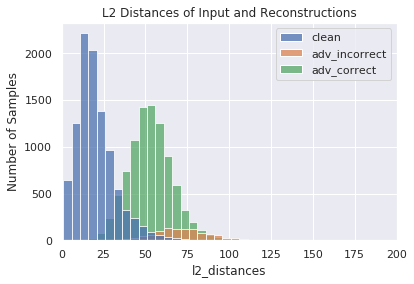

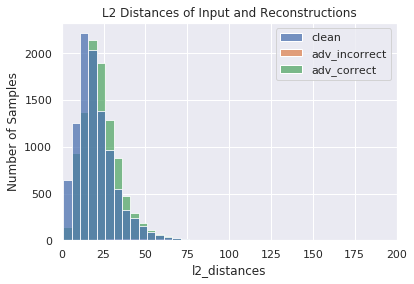

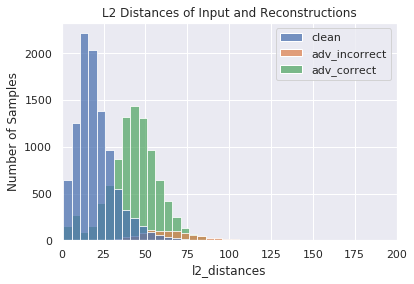

In [20]:
for key in adversary_dict.keys():
    print(key, ":", np.sum(Und_l2[key])/100)
    print(l2_distances_all[key].shape[0])

def plots(adversary):
    clean_l2 = l2_distances_all['Clean']
    adv_l2 = l2_distances_all[adversary][Und_l2[adversary]==False]
    adv_l2_inc = l2_distances_all[adversary][Und_l2[adversary]]

    fig, ax = plt.subplots()
    sns.set_theme()
    sns.histplot({'clean':clean_l2, 'adv_incorrect':adv_l2_inc, 'adv_correct':adv_l2}, bins=range(1, 200, 5), ax=ax, kde=False)
    ax.set_xlabel('l2_distances')
    ax.set_ylabel('Number of Samples')
    ax.set_title('L2 Distances of Input and Reconstructions')
    ax.set_xlim([0, 200])

plots('PGD')
plots('FGSM')
plots('BIM')

In [21]:
att_net = CNN('plusR')
def_net = capsnet()

model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN
# model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = CapsNet
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Untargeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


Clean : 0.83
10000
PGD : 10.48
10000
FGSM : 1.02
10000
BIM : 9.85
10000


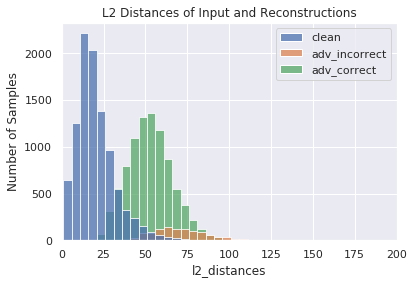

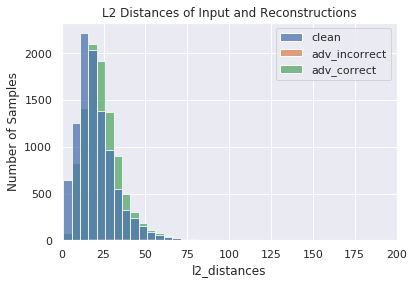

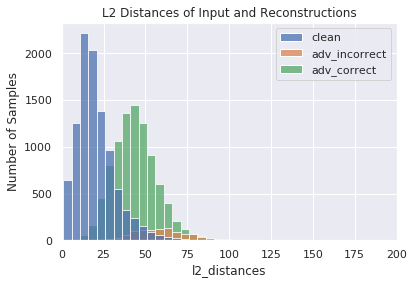

In [22]:
for key in adversary_dict.keys():
    print(key, ":", np.sum(Und_l2[key])/100)
    print(l2_distances_all[key].shape[0])

plots('PGD')
plots('FGSM')
plots('BIM')

In [37]:
att_net = capsnet()
def_net = CNN('plusCR')

# model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN()
model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = capsnet()
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Untargeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [36:19<00:00, 108.98s/it]


3.91
66.94
6.41
54.84


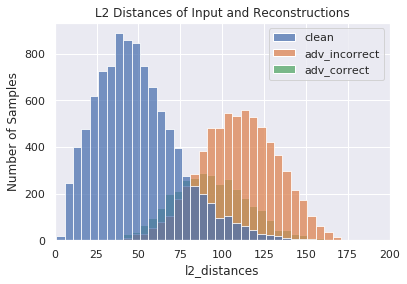

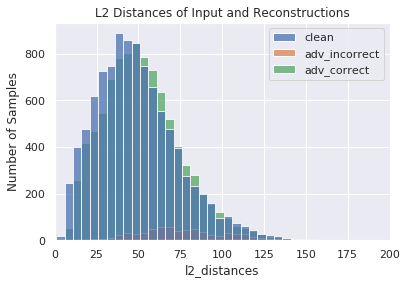

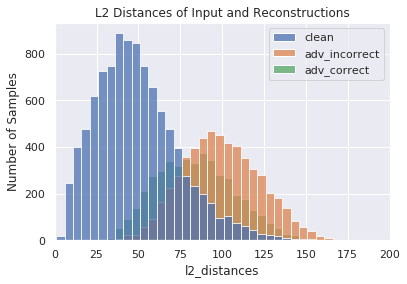

In [38]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')

In [39]:
att_net = capsnet()
def_net = CNN('plusR')

# model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN()
model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = capsnet()
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Untargeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [36:18<00:00, 108.94s/it]


4.54
65.95
7.21
55.64


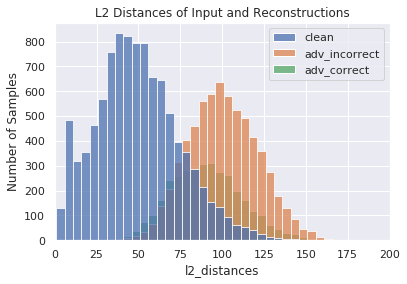

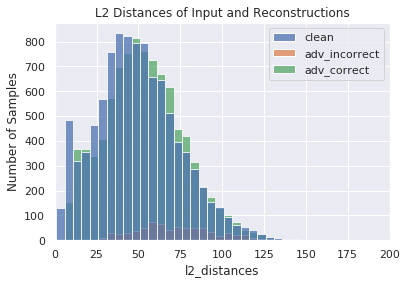

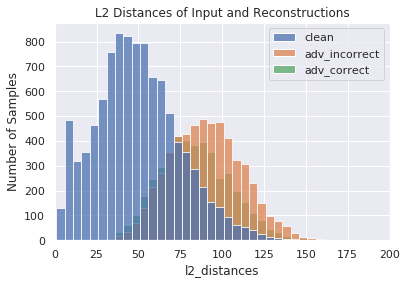

In [40]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')

In [47]:
att_net = CNN('plusCR')
def_net = CNN('plusR')

model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN()
# model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = capsnet()
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Untargeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


4.54
50.89
6.62
25.44


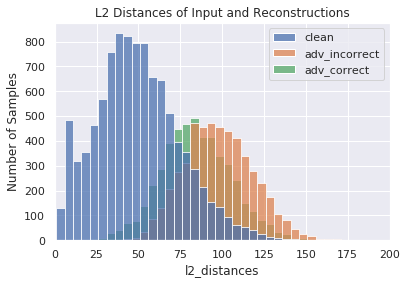

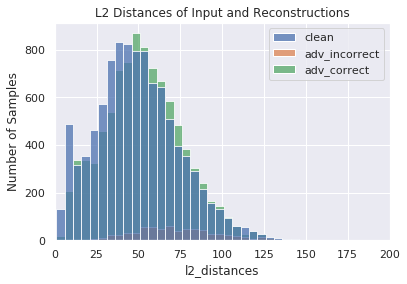

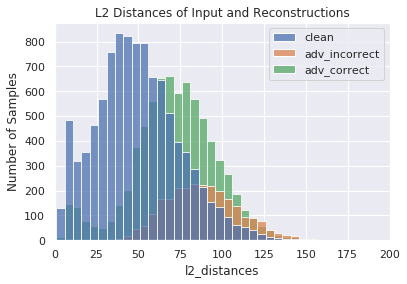

In [48]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')

## White Box Targeted Attack

In [43]:
att_net = CNN('plusCR')
def_net = capsnet()

model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN
# model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = CapsNet
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Targeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


10.35
11.4
11.03
10.88


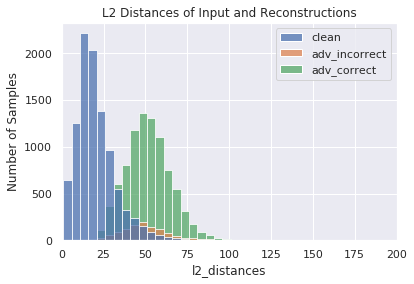

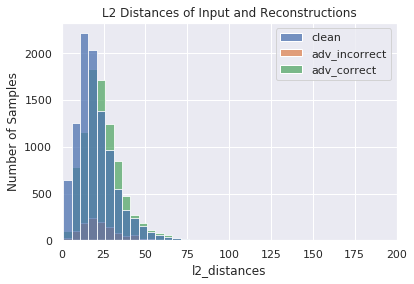

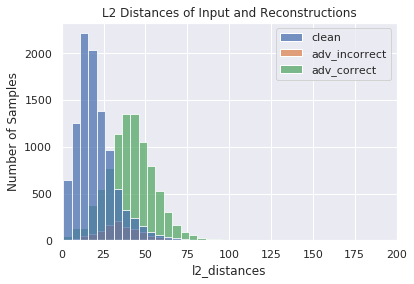

In [44]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')

In [45]:
att_net = CNN('plusR')
def_net = capsnet()

model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN
# model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = CapsNet
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Targeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


10.13
11.06
10.35
10.84


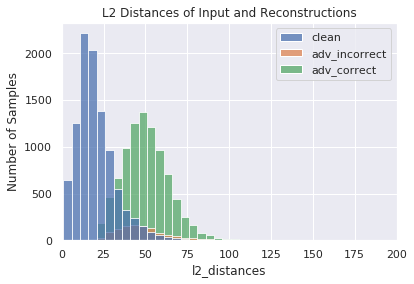

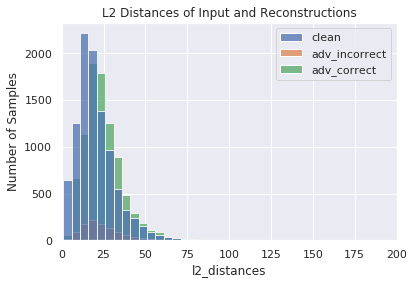

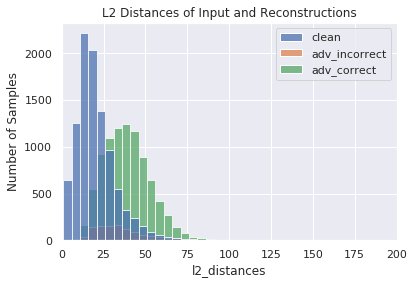

In [46]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')

In [51]:
att_net = CNN('plusR')
def_net = CNN('plusCR')

model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN
# model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = CapsNet
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Targeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


9.87
15.82
10.16
13.77


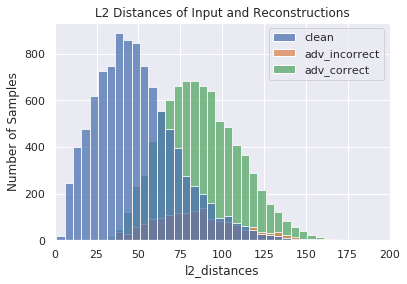

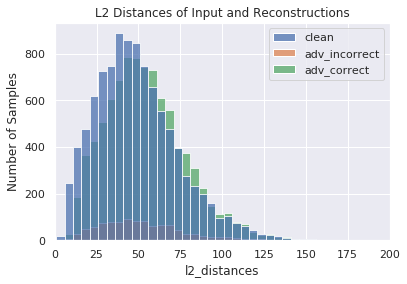

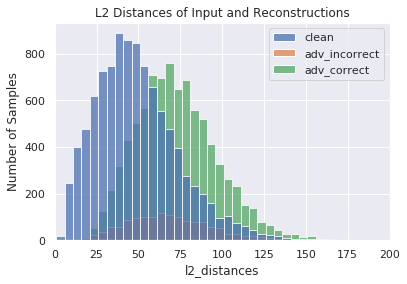

In [52]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')

In [53]:
att_net = CNN('plusCR')
def_net = CNN('plusR')

model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN
# model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = CapsNet
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Targeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


10.24
17.61
10.09
13.79


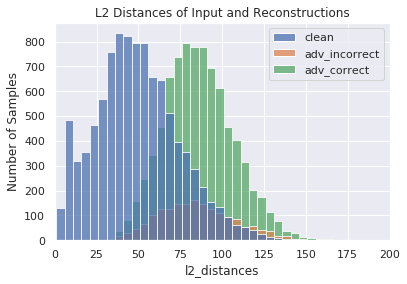

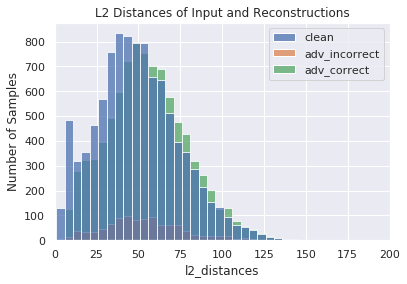

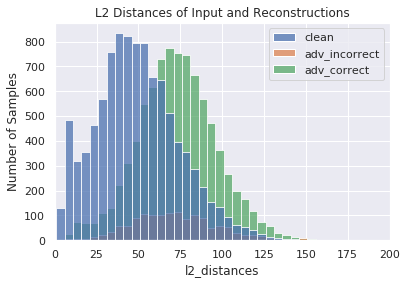

In [54]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')

In [55]:
att_net = capsnet()
def_net = CNN('plusR')

# model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN
model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = CapsNet
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Targeted(def_net, testloader, adversary_dict, Caps_args)

100%|██████████| 20/20 [36:16<00:00, 108.83s/it]


10.39
11.92
10.6
13.46


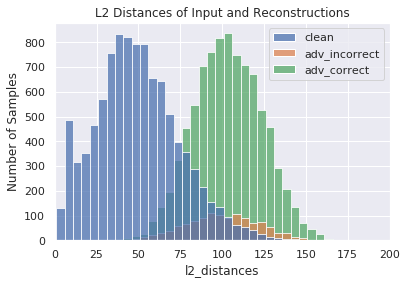

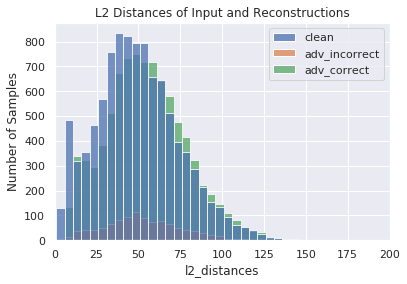

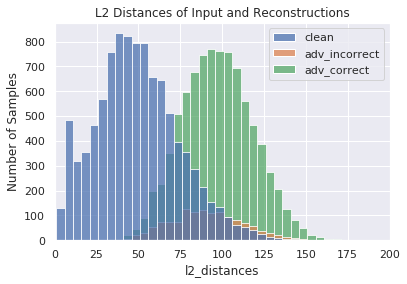

In [57]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')

In [ ]:
att_net = capsnet()
def_net = CNN('plusCR')

# model_for_adversary = Model_for_Adversary(att_net) #if att_net = CNN
model_for_adversary = Model_for_Adversary_CapsNet(att_net) #if att_net = CapsNet
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=100, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(fgsm_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=100, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

l2_distances_all, Und_l2 = WhiteBox_Transfer_Targeted(def_net, testloader, adversary_dict, Caps_args)

 40%|████      | 8/20 [14:50<22:15, 111.28s/it]

In [ ]:
for key in adversary_dict.keys():
    print(np.sum(Und_l2[key])/100)

plots('PGD')
plots('FGSM')
plots('BIM')